# Data Loading

In [8]:
#Imports
import pandas as pd
import json

#Load Data
business_df = pd.read_json('../yelp_data/yelp_academic_dataset_business.json', lines=True)

#Filter by category (Food and restaurants)
#notes to self: fillna for replacing all missing values (NaNs)
restaurants_df = business_df[business_df['categories'].fillna('').str.contains('Restaurants|Food', case=False, na=False)]
# city_counts = business_df['city'].value_counts().head(20)
# print(city_counts)
restaurants_sample = restaurants_df.sample(n=5000, random_state=42)
print(f"Filtered to {len(restaurants_sample)} food-related businesses")

#print(restaurants_sample.head())

Filtered to 5000 food-related businesses


# Load and Join Reviews

In [9]:
# Get business_ids from sampled restaurants/food establishments
sample_ids = set(restaurants_sample['business_id'])

# Load only matching reviews
reviews_sample = pd.read_json('../yelp_data/yelp_academic_dataset_review.json', lines=True, chunksize=100000)

filtered_reviews = pd.concat([
    chunk[chunk['business_id'].isin(sample_ids)]
    for chunk in reviews_sample
])
print(f"Filtered to {len(filtered_reviews)} business-related reviews")

Filtered to 394935 business-related reviews


# Add User Ratings

In [20]:
#get unique user ids from the filtered reviews
user_ids = set(filtered_reviews['user_id'].unique())
print(f"Number of unique users: {len(user_ids)}")

#read and filter users
chunks = pd.read_json('../yelp_data/yelp_academic_dataset_user.json', lines=True, chunksize=100000)
matched_users = pd.concat([
    chunk[chunk['user_id'].isin(user_ids)][['user_id','average_stars','review_count']]
    for chunk in chunks
])

#merge into review data
print(f"Matched {len(matched_users)} users from user data")
reviews_with_user = filtered_reviews.merge(
    matched_users,
    on='user_id',
    how='left'
)

print(reviews_with_user[['user_id', 'average_stars', 'review_count']].head())

Number of unique users: 256898
Matched 256897 users from user data
                  user_id  average_stars  review_count
0  yfFzsLmaWF2d4Sr0UNbBgg           5.00           1.0
1  yobeeTUBfaTBcnk26mXNuA           4.30          30.0
2  bHSoye7R5cL-LVWLxtaxMg           3.00          13.0
3  IKbjLnfBQtEyVzEu8CuOLg           3.87         800.0
4  LWTvg7RlyNLXIf482tXBPw           3.40          10.0


# Adjust Rating Calculation for Bias
Some users tend to rate more harshly or more generously than others, this is to attempt to "normalize" user bias based on their average ratings. Although in this dataset, this is not a prevelant issue since it is centered around US based reviews, if it were a global review data this is good to factor in cultural differences. For example, in Japan, Google average review ratings are much lower and a 3 star rating is equivalent to around a 4.5-5 star here.

In [ ]:
def adjustRating(row):
    #only adjusting for users with a substantial amount of reviews to base off of
    if pd.notnull(row['average_stars']) and pd.notnull(row['review_count']) and row['review_count'] >= 15:
        diff = row['stars'] - row['average_stars']
        return 3.0 + diff #3.0 is a neutral midpoint baseline
    return None

reviews_with_user['adjusted_rating'] = reviews_with_user.apply(adjustRating, axis=1)

In [23]:
# Compare original and adjusted mean ratings
print("Original mean star rating:", reviews_with_user['stars'].mean())
print("Bias-adjusted mean rating:", reviews_with_user['adjusted_rating'].mean())

# Identify top-rated restaurants by average adjusted rating
top_adjusted = reviews_with_user.groupby('business_id')['adjusted_rating'].mean().sort_values(ascending=False).head(10)

# Merge with business metadata to get names
top_adjusted = top_adjusted.reset_index().merge(
    restaurants_sample[['business_id', 'name']],
    on='business_id',
    how='left'
)

print(top_adjusted[['name', 'adjusted_rating']])

Original mean star rating: 3.7893830630356895
Bias-adjusted mean rating: 3.0115365732175894
                             name  adjusted_rating
0               JNS Party Rentals         5.350000
1                       FASTSIGNS         5.210000
2                   New Chong Weh         5.195000
3               Windmill Taphouse         4.970000
4               Peter Piper Pizza         4.780000
5      Bauman Family Apple Butter         4.740000
6          Community Chiropractic         4.640000
7  AJ's Famous Hollywood Hot Dogs         4.630000
8                 Wild Card Pizza         4.616667
9      Sprota's Deli and Catering         4.493333


# Visualize Rating Distributions

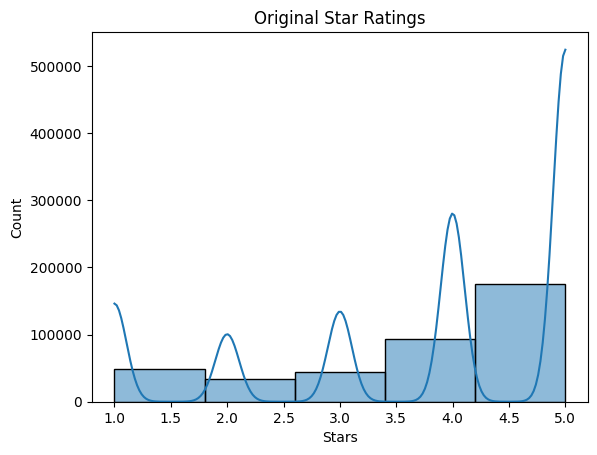

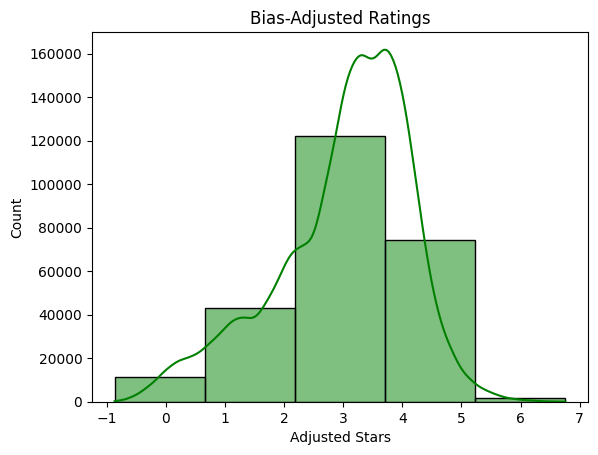

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Original star ratings
sns.histplot(reviews_with_user['stars'], bins=5, kde=True)
plt.title("Original Star Ratings")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.show()

# Bias-adjusted ratings
sns.histplot(reviews_with_user['adjusted_rating'], bins=5, kde=True, color='green')
plt.title("Bias-Adjusted Ratings")
plt.xlabel("Adjusted Stars")
plt.ylabel("Count")
plt.show()
